<a href="https://colab.research.google.com/github/liwenjing2012/Cousera_Capstone/blob/main/Capstone_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cousera Capstone Project : Neighborhoods Battle
Where is better to live in Austin

In [ ]:
#install modules needed
!pip install rtree
!pip install geopandas

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
from shapely.geometry import Point
import geopandas as gpd
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # plotting library
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize




print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [ ]:
CLIENT_ID = "KU0CC2XGBFTS40SCQZYT5C1W4JMNIRA1D5H3SVZCITNDO3XF"
CLIENT_SECRET="HCOL1SIL4HGTJKTXPG34GVCF0YIPNY4PIOTVLDTERRFQRZYD"
VERSION = '20180604'
ACCESS_TOKEN = '0GFYVQWD4RZ2YPEWEFDYCKM0FN5ADDL1KVYPC1PWASSNHZBH'

latitude = 40.715337
longitude = -74.008848
radius = 500
LIMIT = 100
search_query = 'housing'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url
# send GET request and get trending venues
results = requests.get(url).json()
results

In [ ]:
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

In [ ]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

Import criminal report data from github

In [ ]:
url = "https://raw.githubusercontent.com/liwenjing2012/Cousera_Capstone/main/Crime_Reports.csv"
criminal_data = pd.read_csv(url)
criminal_data.head()


In [ ]:
criminal_features = ['Incident Number','Highest Offense Description', 'Category Description', 'Location Type', 'Zip Code', 'Latitude', 'Longitude']
criminal_feature_data = criminal_data[criminal_features]
#criminal_feature_data = criminal_feature_data[-criminal_feature_data['Category Description'].isna()].reset_index(drop=True)
criminal_feature_data['Category']=criminal_feature_data['Category Description'].fillna('Unlabled')
criminal_feature_data = criminal_feature_data.drop(['Category Description','Highest Offense Description'],axis=1)
criminal_feature_data.groupby(['Category']).count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Incident Number,Location Type,Zip Code,Latitude,Longitude
Category,,,,,
Aggravated Assault,2789,2786,2763,2738,2738
Auto Theft,4019,4019,3996,3998,3998
Burglary,4824,4824,4810,4800,4800
Murder,57,57,57,57,57
Rape,557,555,523,0,0
Robbery,1064,1064,1060,1057,1057
Theft,26712,26709,26583,26624,26624
Unlabled,59371,59280,58628,58209,58209


In [ ]:
criminal_feature_data.shape

(99393, 6)

Import neighborhood data from github and merge the two datasets

In [ ]:
url = 'https://raw.githubusercontent.com/liwenjing2012/Cousera_Capstone/main/Neighborhoods.geojson'
geoNeigh = gpd.read_file(url)
geoNeigh_data = geoNeigh[['neighname','geometry']]
#geoNeigh_data['geometry'].centroid

In [ ]:
geoNeigh_data['Lng'] = geoNeigh_data['geometry'].centroid.x
geoNeigh_data['Lat'] = geoNeigh_data['geometry'].centroid.y
geoNeigh_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,neighname,geometry,Lng,Lat
0,ANDERSON MILL,"MULTIPOLYGON (((-97.79231 30.45671, -97.79154 ...",-97.809771,30.441196
1,WINDSOR PARK,"MULTIPOLYGON (((-97.67076 30.30854, -97.67204 ...",-97.692326,30.311575
2,DAWSON,"MULTIPOLYGON (((-97.75353 30.23876, -97.75472 ...",-97.761797,30.232695
3,WEST UNIVERSITY,"MULTIPOLYGON (((-97.73815 30.30275, -97.73860 ...",-97.745308,30.291838
4,MLK,"MULTIPOLYGON (((-97.68262 30.28587, -97.68372 ...",-97.692304,30.283831


In [ ]:
criminal_gdf = gpd.GeoDataFrame(
    criminal_feature_data, geometry=gpd.points_from_xy(criminal_feature_data.Longitude, criminal_feature_data.Latitude))

In [ ]:
criminal_gdf.set_crs(epsg=4326, inplace=True)
joined_gdf = gpd.sjoin(criminal_gdf, geoNeigh_data, op='within').reset_index(drop=True).drop(['index_right'],axis=1)
joined_gdf = joined_gdf.drop(['Location Type','Zip Code','Latitude','Longitude','geometry'],axis = 1)

In [205]:
joined_gdf.groupby(['neighname']).size()

neighname
ALLANDALE                 698
ANDERSON MILL            1402
AVERY RANCH--LAKELINE    1414
BARTON CREEK MALL         428
BARTON HILLS              654
                         ... 
WINDSOR HILLS             957
WINDSOR PARK             2600
WINDSOR ROAD              226
WOOTEN                    688
ZILKER                   1070
Length: 102, dtype: int64

In [218]:
df = joined_gdf.copy()
df1 = df[['neighname','Lat','Lng']].drop_duplicates().reset_index(drop = True)
for name in criminal_feature_data['Category'].unique():
  if  name == 'Rape': #Rape has no lat & long
    name = 'Total'
    df[name] = df.groupby(['neighname'])['Incident Number'].transform('count')
    
  else:
    df[name] = df[df['Category']==name].groupby(['neighname'])['Incident Number'].transform('count')
    
  df_temp = df[['neighname',name]].drop_duplicates().reset_index(drop = True)
  df_temp = df_temp[-df_temp[name].isna()].reset_index(drop = True)
  df1 = pd.merge(df1,df_temp,how = 'left', on = ['neighname'])
                 

  df1 = df1.fillna(0)
  df1 = df1.astype({name:'int32'})



df1.head()

,neighname,Lat,Lng,Robbery,Unlabled,Burglary,Theft,Aggravated Assault,Auto Theft,Total,Murder
0,WINDSOR HILLS,30.363944,-97.676293,15,588,54,212,38,49,957,1
1,CHERRY CREEK,30.193485,-97.825970,2,979,41,333,30,32,1418,1
2,MLK,30.283831,-97.692304,7,550,38,114,41,17,767,0
3,DAWSON,30.232695,-97.761797,7,310,23,154,8,22,524,0
4,WEST UNIVERSITY,30.291838,-97.745308,15,673,83,706,15,149,1641,0


In [215]:
map_austin = folium.Map(location=[30.2672, -97.7431], zoom_start=11)

# add markers to map
for lat, lng, neighborhood,cnt in zip(df1['Lat'], df1['Lng'], df1['neighname'],df1['Total']):
    label = '{},{} crimes'.format(neighborhood,cnt)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin

In [219]:
kclusters = 5

df2 = df1.copy()
df_clustering = df1.drop(['neighname','Total','Lat','Lng'],1)
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(df_clustering)
kmeans.labels_
df2.insert(0,'clusters',kmeans.labels_)
df2

,clusters,neighname,Lat,Lng,Robbery,Unlabled,Burglary,Theft,Aggravated Assault,Auto Theft,Total,Murder
0,0,WINDSOR HILLS,30.363944,-97.676293,15,588,54,212,38,49,957,1
1,3,CHERRY CREEK,30.193485,-97.825970,2,979,41,333,30,32,1418,1
2,0,MLK,30.283831,-97.692304,7,550,38,114,41,17,767,0
3,2,DAWSON,30.232695,-97.761797,7,310,23,154,8,22,524,0
4,3,WEST UNIVERSITY,30.291838,-97.745308,15,673,83,706,15,149,1641,0
...,...,...,...,...,...,...,...,...,...,...,...,...
97,2,MANSFIELD--RIVER PLACE,30.364146,-97.854812,0,171,10,96,4,9,290,0
98,2,DAVENPORT LAKE AUSTIN,30.329121,-97.836106,2,72,9,66,1,3,153,0
99,2,OLD ENFIELD,30.285827,-97.756976,0,44,3,26,1,3,77,0
100,2,CIRCLE C SOUTH,30.186829,-97.900259,0,185,2,42,0,5,234,0


KeyError: ignored

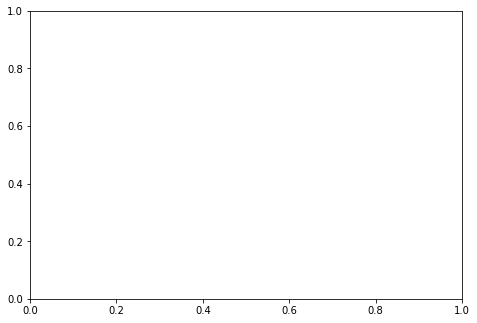

In [229]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df1['clusters'],df1['Robbery'])
plt.show()

In [220]:
map_clusters = folium.Map(location=[30.2672, -97.7431],zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#ys
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, neighborhood,cluster in zip(df1['Lat'],df1['Lng'],df2['neighname'],df2['clusters']):
  label = folium.Popup(str(neighborhood) + 'Cluster' + str(cluster), parse_html=True)
  folium.CircleMarker(
      [lat,lng],
      radius = 5,
      popup = label,
      color = rainbow[cluster-1],
      fill = True,
      fill_color = rainbow[cluster-1],
      fill_opacity = 0.7).add_to(map_clusters)

map_clusters